In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import time

In [2]:
#############################################################################
rseed = 1           # random generator seed
t_sim  = 1000.0         # simulation time
# sim_params = {'t_sim': t_sim}

# Network parameters
N     = 1000        # number of neurons
g     = 10.0         # inhibition/excitation ratio
frac  = 80000.0/N**0.5
w_ex  = frac*0.15 # mV
w_in  = -g * w_ex
delay = 1.5 #in ms
# w = 0.01

# Neuron parameters
tau_m       = 10.0  # membrane time constant in (ms)
t_ref       = 2.0   # refractory period in (ms)
V_reset     = 0.0   # reset membrane potential in (mV)
V_rest      = 0.0   # resting membrane potential (mV)

# Phi parameters
alpha       = 1.0/tau_m
gamma       = 0.1           # slope of the firing probability funtion in (1/mV)
r           = 0.4           # curvature of the firing probability function (unitless)
V_rheo      = 15.0          # rheobase potential, potential in which firing probability becomes > 0 in (mV)

# Synapse parameters
tau_syn_ex  = 0.5 # excitatory synaptic time constant in (ms)
tau_syn_in  = 0.5 # inhibitory synaptic time constant in (ms)
beta_ex     = 1.0/tau_syn_ex
beta_in     = 1.0/tau_syn_in
beta        = beta_ex

# External input parameters
I_ext       = 100.0 # constant current in (pA)

# Poisson background parameters
poisson_rate   = 8.0*10 # rate of poisson spike input in (Hz)
poisson_weight = 87.8 # weight of poisson input in (pA)

In [3]:
# np.repeat([1,2,3],5)

In [4]:
# pos_idx[pre_idx==254.76897643315343]
# pre_idx[0]
# pre_idx

In [5]:
np.random.seed(rseed)

def fixed_indegree(Ce, Ci, Nexct, Ninhb, W, g):
	pre_ex  = np.random.uniform(0, Nexct, Ce*(Nexct+Ninhb))
	# print(pre_ex)
	pre_ex = np.ceil(pre_ex)
	# print(pre_ex)
	pos_ex  = np.repeat( np.arange(0, Nexct+Ninhb), Ce)
	# print(pos_ex)

	pre_in  = np.random.uniform(Nexct, Nexct+Ninhb, Ci*(Nexct+Ninhb))
	# print(pre_in)
	pre_in = np.ceil(pre_in)
	# print(pre_in)
	pos_in  = np.repeat( np.arange(0, Nexct+Ninhb), Ci)
	# print(pos_in)


	pre_idx = np.concatenate((pre_ex, pre_in))
	pos_idx = np.concatenate((pos_ex, pos_in))

	weights = np.concatenate( (W*np.ones(pre_ex.shape[0]), -g*W*np.ones(pre_in.shape[0])) )

	return pre_idx, pos_idx, weights


def brunel_graph(N, w_ex, g, save_graph=False):

	f     = 0.8         	# fraction of excitatory neurons
	p	  = 0.1				# probability of connection
	Nexct = int(f * N)  	# number of excitatory neurons
	Ninhb = N-Nexct			# number of inhibitory neurons
	Ce    = int(Nexct*p)
	Ci    = int(Ce*0.25)

	pre_idx, pos_idx, W = fixed_indegree(Ce, Ci, Nexct, Ninhb, w_ex, g)

	post_list = []
	for i in range(Nexct+Ninhb):
		post_list.append([pos_idx[pre_idx==i],W[pre_idx==i]])

	if save_graph == True:
		np.save('graph/brunel_seed_'+str(s)+'.npy', post_list)

	return post_list

def all_to_all(N, w):
	conn_mat = np.ones((N,N))*w

	return conn_mat



In [6]:
#phi function
'''def phi(V, v_half, slope):
    #return 1.0/(1.0+np.exp(-(V-v_half)/slope))
    # return (1/27.07) * np.exp((V-v_half)/slope) + 1e-4
    phi_u = slope*V#+0.1
    phi_u[phi_u>1] = 1
    phi_u[phi_u<0] = 0
    return phi_u'''


def phi(V, gamma, r):
    V_diff = V - V_rheo
    idx_neg = np.where(V_diff < 0)
    V_diff[idx_neg] = 0.0
    phi_u = (np.power(gamma * V_diff, r))/100.0#*10.0
    # Phi in kHz - divided by 0.1
    # phi_u[phi_u<0] = 0
    return phi_u


#function to evaluate the model
def evaluate(post_list):
    #initial conditions
    V = np.random.uniform(0.0, V_rheo+1.0, size=N ) # V_rheo - V repouso
    phi_u = np.zeros(N)          #array to store phi values
    I_syn = np.zeros(N)          #array to store synaptic current values
    last_spike = np.zeros(N)

    #array to store spikes
    spk_t = [] # tempo do spike
    spk_id = [] # id do neuronio (0 a N-1) que teve o spike

    trun = 0.0
    while (trun < t_sim):
        #compute phi(T-dt) # ?????????????????????????????????????????
        phi_u = phi(V, gamma, r)
        S = np.sum(phi_u)
        if S == 0: break
        unif = np.random.rand()
        dt = -np.log(unif)/S; # ?????????????????????????????????????????

        #compute V(T)
        # V = (V-V_rest)*np.exp(-alpha*dt) + V_rest + I_ext + I_syn #WRONG
        V = (V-V_rest)*np.exp(-alpha*dt) \
            + I_syn*np.exp(-beta*dt)*(np.exp((beta-alpha)*dt)-1)/(beta-alpha) \
            + I_ext*np.exp(-beta*dt)*(np.exp((beta)*dt)-1)/(beta)
        # ?????????????????????????????????????????

        # compute I at time T
        I_syn = I_syn*np.exp(-beta*dt)

        #compute phi(V) at time T
        phi_u = phi(V, gamma, r)

        unif = np.random.uniform(low=0.0, high=S)

        S_new = np.sum(phi_u)
        trun += dt

        if unif<=S_new:
            phi_cumsum = np.cumsum(phi_u)
            neuron_id = np.where(unif<=phi_cumsum)[0][0] # acha o neuronio tal que a uniforme caiu nele

            # checking refractory period
            if last_spike[neuron_id]==0 or (trun-last_spike[neuron_id])>=t_ref: # ????????????????????????????????????????? se isso for False, o potencial dele zera mas n conta como spike.........

                # updating of postsynaptic currents:
                I_syn[post_list[neuron_id][0]] += post_list[neuron_id][1]

                # updating of postsynaptic potentials:
                # V[post_list[neuron_id][0]] += post_list[neuron_id][1]

                # updating of last spike list:
                last_spike[neuron_id] = trun

                # recording spike time and neuron index:
                spk_t.append(trun)
                spk_id.append(neuron_id)

            
            # ????????????????????????????????????????? acho que devia ter tab na linha abaixo (estar dentro do "if last_spike[neuron_id]==0 or (trun-last_spike[neuron_id])>=t_ref" )
            V[neuron_id] = V_reset # Zera potencial


    print('\nNumber of spikes per neuron: ' + str(len(spk_t)/N))

    # return np.array(spk_t), np.array(spk_id)
    return np.array(spk_t), np.array(spk_id), I_syn


In [7]:
#parameters
np.random.seed(rseed)    #seed for the random number generator

#random network 80% excitatory and 20% inhibitory:
print('\nBuilding graph...')
init = time.time()
post_list = brunel_graph(N, w_ex, g, save_graph=False)
end  = time.time()
print('...time spent: ' + str(end-init))
# post_list


Building graph...
...time spent: 0.1295309066772461



Running the simulation...

Number of spikes per neuron: 10.223

Simulation time: 1.1953797340393066


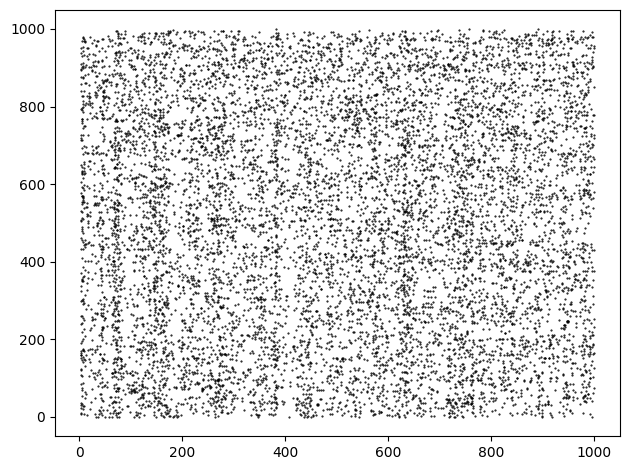

In [8]:
#running simulation
print('\nRunning the simulation...')
init = time.time()
# spk_t, spk_id = evaluate(post_list)
spk_t, spk_id, I_syn = evaluate(post_list)
end  = time.time()
print('\nSimulation time: ' + str(end-init))

#plot graph
plt.plot(spk_t, spk_id, '.k', markersize=1.0)
# plt.plot(spk_t[spk_id<=N*0.8],spk_id[spk_id<=N*0.8], '.k', markersize=1.0)
# plt.plot(spk_t[spk_id>N*0.8],spk_id[spk_id>N*0.8], '.r', markersize=1.0)
plt.tight_layout()
plt.show()
# plt.savefig('array.png', dpi = 600)
# plt.close()


## Analise

In [9]:
N, w_ex, g

(1000, 379.47331922020555, 10.0)

In [10]:
f     = 0.8         	# fraction of excitatory neurons
p	  = 0.1				# probability of connection
Nexct = int(f * N)  	# number of excitatory neurons
Ninhb = N-Nexct			# number of inhibitory neurons
Ce    = int(Nexct*p)
Ci    = int(Ce*0.25)

pre_idx, pos_idx, W = fixed_indegree(Ce, Ci, Nexct, Ninhb, w_ex, g)
W

array([  379.47331922,   379.47331922,   379.47331922, ...,
       -3794.7331922 , -3794.7331922 , -3794.7331922 ])

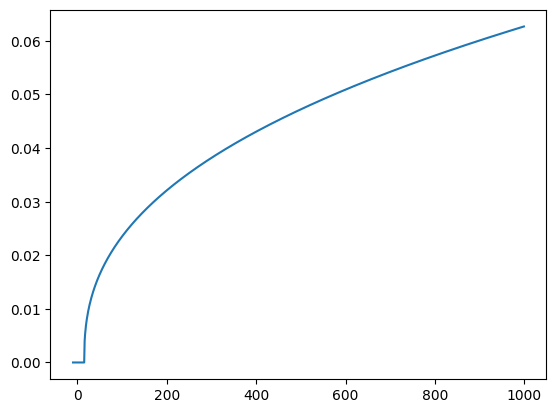

In [11]:
V = np.arange(-10,1000,1)
p = phi(V, gamma,r)
plt.plot(V, p)